In [1]:
import sys
sys.path.insert(0, '..')

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from datetime import datetime
from tqdm import tqdm
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

from core.multimodal.dataset2 import VPSMDatasetV2
from core.multimodal.model import ModelV1
from util.parallelzipfile import ParallelZipFile as ZipFile
from core.data.utils import preprocess_spectra, readLRSFits, preprocess_lc, get_vlc

In [2]:
METADATA_COLS = [
    'mean_vmag', 'amplitude', 'period', 'phot_g_mean_mag', 'e_phot_g_mean_mag', 'lksl_statistic',
    'rfr_score', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe'
]

CLASSES = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW',
           'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']

In [3]:
train_dataset = VPSMDatasetV2(split='train', classes=CLASSES)

In [4]:
idx = 0
el = train_dataset.df.iloc[idx]
label = train_dataset.target2id[el['target']]

In [13]:
crop = 'random' if train_dataset.split == 'train' else 'center'
photometry = get_vlc(el['name'], train_dataset.v_prefix, train_dataset.reader_v)

In [14]:
spectra = readLRSFits(os.path.join(train_dataset.lamost_spec_dir, el['spec_filename']), train_dataset.z_corr)

In [15]:
photometry.shape

(307, 3)

In [16]:
spectra.shape

(3909, 3)

In [23]:
def add_noise(X):
    time, flux, flux_err = X[:, 0], X[:, 1], X[:, 2]
    
    # Sample noise from a normal distribution using flux_err
    noise = np.random.normal(0, flux_err)
    
    # Add the noise to the flux
    flux_noisy = flux + noise
    
    # Combine time, noisy flux, and flux_err back into the original shape
    X_noisy = np.column_stack((time, flux_noisy, flux_err))
    
    return X_noisy

In [24]:
noisy_photometry = add_noise(photometry)
noisy_spectra = add_noise(spectra)

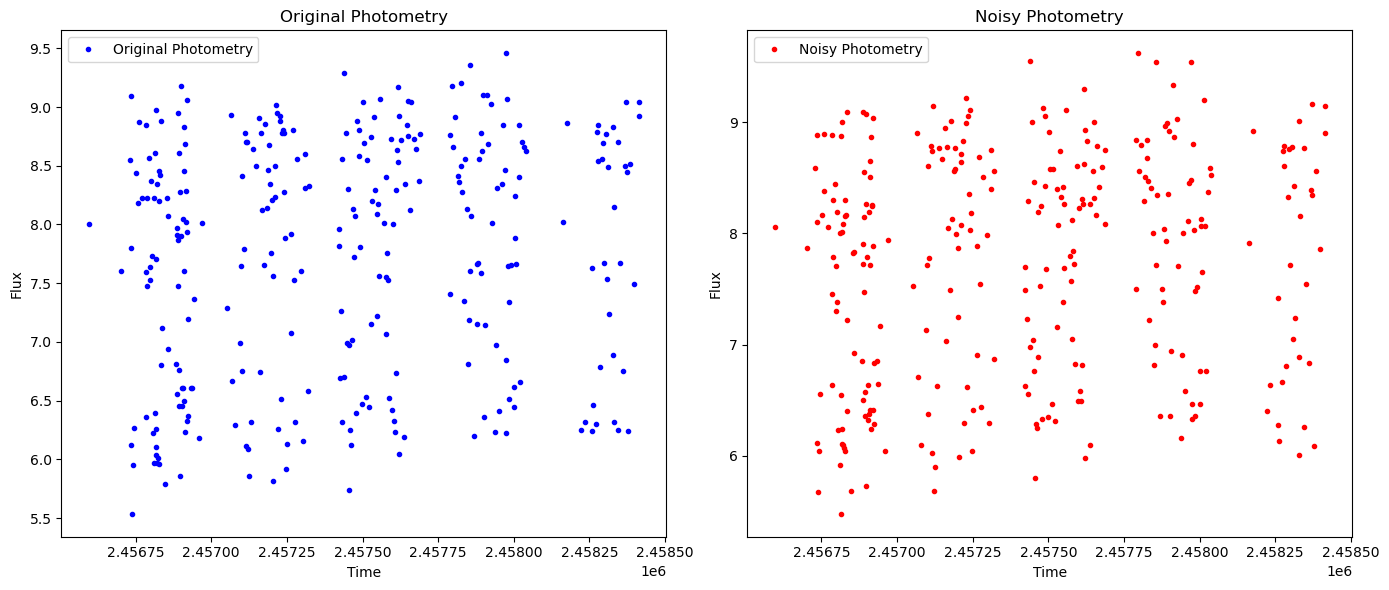

In [27]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(photometry[:, 0], photometry[:, 1], '.', label='Original Photometry', color='blue')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Original Photometry')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(noisy_photometry[:, 0], noisy_photometry[:, 1], '.', label='Noisy Photometry', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Noisy Photometry')
plt.legend()

plt.tight_layout()
plt.show()

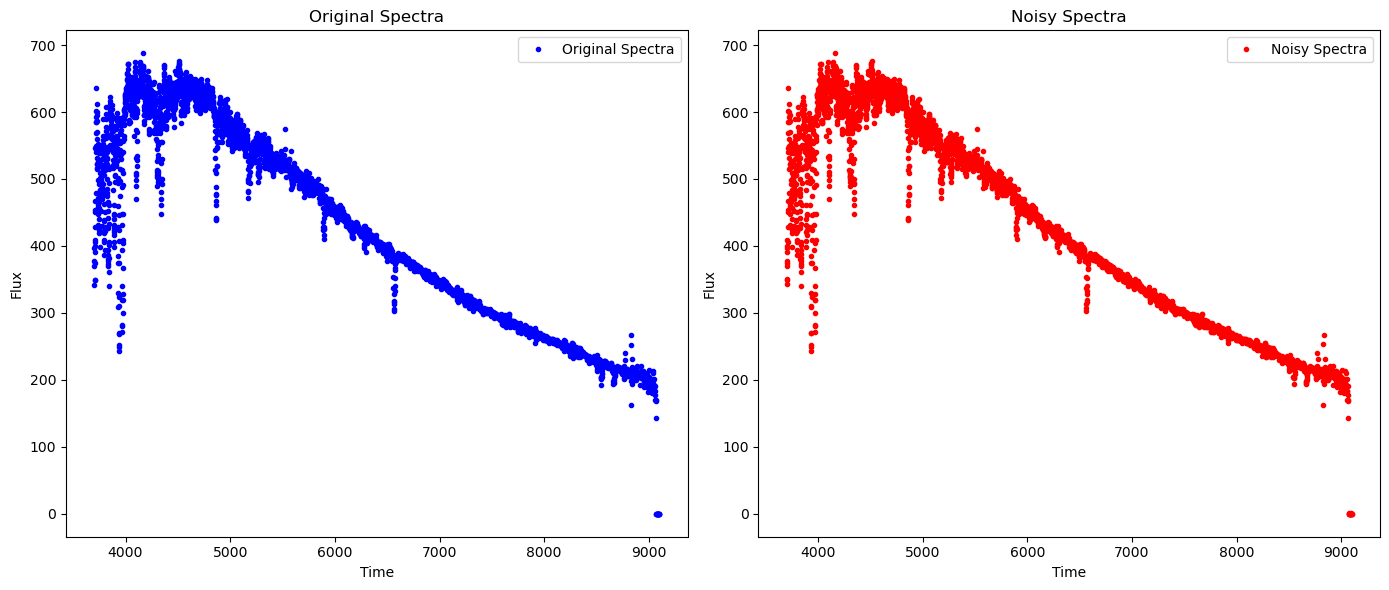

In [28]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(spectra[:, 0], spectra[:, 1], '.', label='Original Spectra', color='blue')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Original Spectra')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(noisy_spectra[:, 0], noisy_spectra[:, 1], '.', label='Noisy Spectra', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Noisy Spectra')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
photometry.dtype, noisy_photometry.dtype

(dtype('float64'), dtype('float64'))

In [55]:
metadata = el[train_dataset.metadata_cols].values.astype(np.float32)

In [56]:
metadata.dtype

dtype('float32')

In [57]:
metadata

array([ 0.03927242, -0.01260953, -1.1855444 ,  0.32948515,  0.18922117,
       -1.6071811 ,  1.5154452 , -0.16260582, -0.08377901,  0.54264504,
        0.18217687, -0.9002048 ,  0.07036976, -0.36748087,  0.25845656,
        0.31998947, -0.3351472 , -0.06027484, -0.28351715,  0.8503525 ,
        0.11592878,  0.93698204,  0.03956221,  0.93515104, -0.03785059,
        0.9080568 , -0.43590912,  0.8980582 , -0.30925748,  1.1313322 ,
        0.9739548 , -1.1122825 , -0.08339138,  1.0332879 , -0.4057979 ,
       -0.13946654], dtype=float32)

In [63]:
def augment_metadata(metadata, noise_level=0.01):
    # Generate Gaussian noise
-    
    # Add noise to metadata
    augmented_metadata = metadata + noise
        
    return augmented_metadata

In [64]:
noisy_metadata = augment_metadata(metadata, noise_level=0.01)

In [65]:
noisy_metadata.dtype

dtype('float32')

In [42]:
for i in range(len(metadata)):
    print(metadata[i], noisy_metadata[i])

0.039272424 0.028881557404314875
-0.012609532 -0.01189847641000321
-1.1855444 -1.187875634161182
0.32948515 0.32558649195351735
0.18922117 0.17195596340622227
-1.6071811 -1.6174570497492318
1.5154452 1.5105862841501037
-0.16260582 -0.15365543027994666
-0.08377901 -0.08092077229238652
0.54264504 0.5520417796545039
0.18217687 0.1946060069118843
-0.9002048 -0.8969116862650954
0.07036976 0.07177269181869032
-0.36748087 -0.3772108140284366
0.25845656 0.27832327063485357
0.31998947 0.3058110319105379
-0.3351472 -0.33395986113283815
-0.06027484 -0.051946849365791296
-0.28351715 -0.2750497762956858
0.8503525 0.8388016348066664
0.115928784 0.1117297539841186
0.93698204 0.9289924879157252
0.039562214 0.019757871870265776
0.93515104 0.9364543079714962
-0.03785059 -0.045026742522504146
0.9080568 0.9231116184441899
-0.43590912 -0.42975737784673573
0.8980582 0.8984721955427905
-0.30925748 -0.31398447284560504
1.1313322 1.132483319740215
0.9739548 0.9713960586319189
-1.1122825 -1.1115871234832124
-0.